# Preprocessing pt.2

Getting reconstructions of the power generation values and top two principal components of the coefficients

In [1]:
### ipyleaflet required to run the map codes in data exploration
# !pip install ipyleaflet

# Use these commands in terminal
### Install ipyleaflet:                conda install -c conda-forge ipyleaflet
### Install Node.js:                   conda install -c anaconda nodejs
### Install the JupyterLab extension:  jupyter labextension install @jupyter-widgets/jupyterlab-manager jupyter-leaflet

# RUN THE FOLLOWING COMMAND IN JUPYTER TERMINAL
# jupyter labextension develop . --overwrite

In [2]:
### Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors

import ipyleaflet as ipy

from pyspark import SparkContext
import pyspark.sql.functions as F
import pyspark.ml.functions as M
from pyspark.sql import SQLContext, SparkSession
from pyspark.sql import Window as W
from pyspark.sql.types import *
from pyspark.ml.feature import PCA, VectorAssembler
from pyspark.ml.linalg import Vectors

import os
import sys
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable



Matplotlib created a temporary cache directory at /tmp/matplotlib-auj7a325 because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [3]:
### Notes from prof's example notebook
# #Make sure you allocate enough memory per core. if you chose 3 cores you should select 6GB in your per Node setting. (presumably 2GB per core)

### For server
# 32 nodes
# 64g

## Start Spark context
total_nodes = 10
memory_per_node = 120

driver_memory = f"{memory_per_node}g"
executor_memory = f"{int(memory_per_node/total_nodes)}g"
n_executors = total_nodes - 1
print(f"Driver memory: {driver_memory}\nExecutor memory: {executor_memory}\nNumber of executors: {n_executors}\n")
try:
    print("Initializing SparkContext")
    sc = SparkSession.builder.config("spark.driver.memory", driver_memory) \
                             .config("spark.executor.memory", executor_memory) \
                             .config('spark.local.dir', "test_dir/") \
                             .config("spark.driver.maxResultSize", "16g") \
                             .config("spark.executor.instances", n_executors) \
                             .getOrCreate()
except:
    print("Starting new SparkContext")
    sc.stop()
    sc = SparkSession.builder.config("spark.driver.memory", driver_memory) \
                             .config("spark.executor.memory", executor_memory) \
                             .config('spark.local.dir', "test_dir/") \
                             .config("spark.driver.maxResultSize", "16g") \
                             .config("spark.executor.instances", n_executors) \
                             .appName("MyApp") \
                             .config("spark.jars.packages", "com.microsoft.azure:synapseml_2.12:0.9.4") \
                             .config("spark.jars.repositories", "https://mmlspark.azureedge.net/maven") \
                             .getOrCreate()
print(sc)

# Start SQL Context
sqlContext = SQLContext(sc)

# Add sc parameters
sc.getActiveSession()

Driver memory: 120g
Executor memory: 12g
Number of executors: 9

Initializing SparkContext


/usr/local/spark/python/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [4]:
%%time
### Load datasets
df_type = 30

### Open the preprocessed dataset
df = sqlContext.read.load("preprocessed_df_single/preprocessed_df.parquet") \
               .withColumn("id", F.monotonically_increasing_id()) \
               .select("id", \
                       F.col("_1").alias("ss_id"), \
                       F.col("_2").alias("stamp_date"), \
                       F.col("_3").alias("power_kW_values"), \
                       F.col("_4").alias("coefficients") \
                      ) \
               .cache() 
df_count = df.count()
df_count = df.count()

# metadata
meta_filename = "metadata.csv"
df_meta = sc.read.csv(meta_filename, inferSchema=True, header=True)
df_meta_count = df_meta.count()

### Comments
print(f"30min dataset has {df_count} rows")
df.show(3)
print(f"Meta dataset has {df_meta_count} rows")
df_meta.show(3)
print("/nTable schemas/n")
print(f"Schema of the {df_type} min time series data table") ###
df.printSchema()
print("Schema of the metadata table")
df_meta.printSchema()

### Since metadata table is so small, convert to Pandas
df_meta = df_meta.toPandas()

30min dataset has 54919174 rows
+---+-----+----------+--------------------+--------------------+
| id|ss_id|stamp_date|     power_kW_values|        coefficients|
+---+-----+----------+--------------------+--------------------+
|  0| 2405|2012-01-21|[0.0, 0.0, 0.0, 0...|[0.49785779737625...|
|  1| 2405|2012-02-15|[0.0, 0.0, 0.0, 0...|[1.27955253409150...|
|  2| 2405|2012-07-25|[0.0, 0.0, 0.0, 0...|[1.77050233549690...|
+---+-----+----------+--------------------+--------------------+
only showing top 3 rows

Meta dataset has 24662 rows
+-----+----------------+-----------------+---------+-----------+----+----+--------------+
|ss_id|latitude_rounded|longitude_rounded|  llsoacd|orientation|tilt| kwp|operational_at|
+-----+----------------+-----------------+---------+-----------+----+----+--------------+
| 2405|           53.53|            -1.63|E01007430|      180.0|35.0|3.36|    2010-11-18|
| 2406|           54.88|            -1.38|E01008780|      315.0|30.0|1.89|    2010-12-03|
| 2407|   

Shape of the basis matrix: (21, 48)

The following sinusoids are used to model the curves:
0.2041241452319315/sqrt(2) * cos(0*x)
0.2041241452319315 * cos(1*x)
0.2041241452319315 * sin(1*x)
0.2041241452319315 * cos(2*x)
0.2041241452319315 * sin(2*x)
0.2041241452319315 * cos(3*x)
0.2041241452319315 * sin(3*x)
0.2041241452319315 * cos(4*x)
0.2041241452319315 * sin(4*x)
0.2041241452319315 * cos(5*x)
0.2041241452319315 * sin(5*x)
0.2041241452319315 * cos(6*x)
0.2041241452319315 * sin(6*x)
0.2041241452319315 * cos(7*x)
0.2041241452319315 * sin(7*x)
0.2041241452319315 * cos(8*x)
0.2041241452319315 * sin(8*x)
0.2041241452319315 * cos(9*x)
0.2041241452319315 * sin(9*x)
0.2041241452319315 * cos(10*x)
0.2041241452319315 * sin(10*x)


Plotting basis sinusoids (The more sinusoids, the busier the plot)

CPU times: user 14.9 ms, sys: 3.92 ms, total: 18.8 ms
Wall time: 19.8 ms


Text(0.5, 1.0, 'Plotting the first 5 sinusoids')

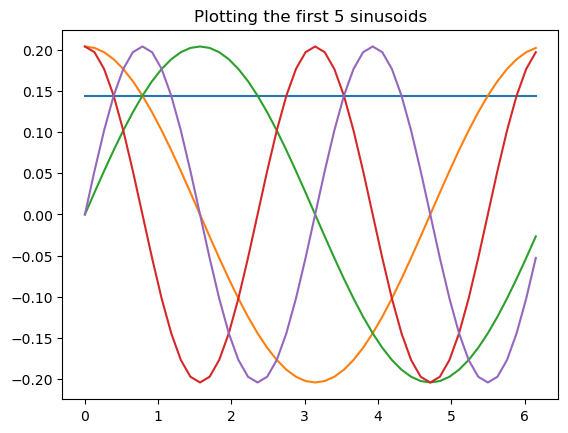

In [6]:
%%time
### Define necessary constants to set up the basis
n_sinusoid_pairs = 10 #--> Adds a pair of sinusoids at increasing frequencies (for 1 + 2*n_sinusoid_pairs total)
max_timestamps = 48 # The number of 30-min intervals in a day

### Define orthonormal basis (sinusoids for Fourier Transform)
step = 2*np.pi/max_timestamps
x = np.arange(0, 2*np.pi, step)
const = np.sqrt(step/np.pi)

basis = []
basis.append(np.array(np.cos(0*x)) * const/np.sqrt(2))
for i in range(0, n_sinusoid_pairs):
    i += 1
    basis.append(np.array(np.cos(i*x))*const)
    basis.append(np.array(np.sin(i*x))*const)
    
basis = np.array(basis)
print(f"Shape of the basis matrix: {basis.shape}")
print()
print("The following sinusoids are used to model the curves:")
print(f"{const}/sqrt(2) * cos(0*x)")
for i in np.arange(1, n_sinusoid_pairs+1):
    print(f"{const} * cos({i}*x)")
    print(f"{const} * sin({i}*x)")
print()
        
print("\nPlotting basis sinusoids (The more sinusoids, the busier the plot)\n")

# for i in range(0, basis.shape[0]):
for i in range(0, 5):
    plt.plot(x, basis[i])
plt.title("Plotting the first 5 sinusoids")

In [7]:
### Save the basis
pd.DataFrame(basis).to_csv("basis.csv", header=False, index=False)

Coefficient indices for the ss_id/date pairings in descending order of coefficient magnitude
0, 2405, 2012-01-21: [ 1  0  3  5  7 14 12 11 16 20 19  4 13  6 10 17  2  9  8 18 15]
30, 2407, 2010-12-07: [ 1  3  0  5  7  9 11 20  6  4 17  8 19 15 18  2 10 16 12 14 13]
2, 2405, 2012-07-25: [ 1  0  3  4  6 19  2 14 16 15 13  8  9  7 17 18 12 10 11  5 20]
95, 2411, 2011-02-27: [ 1  0  3  8 10  6 12 17 19 15  5  4 14 13  9 11 16  2  7 18 20]


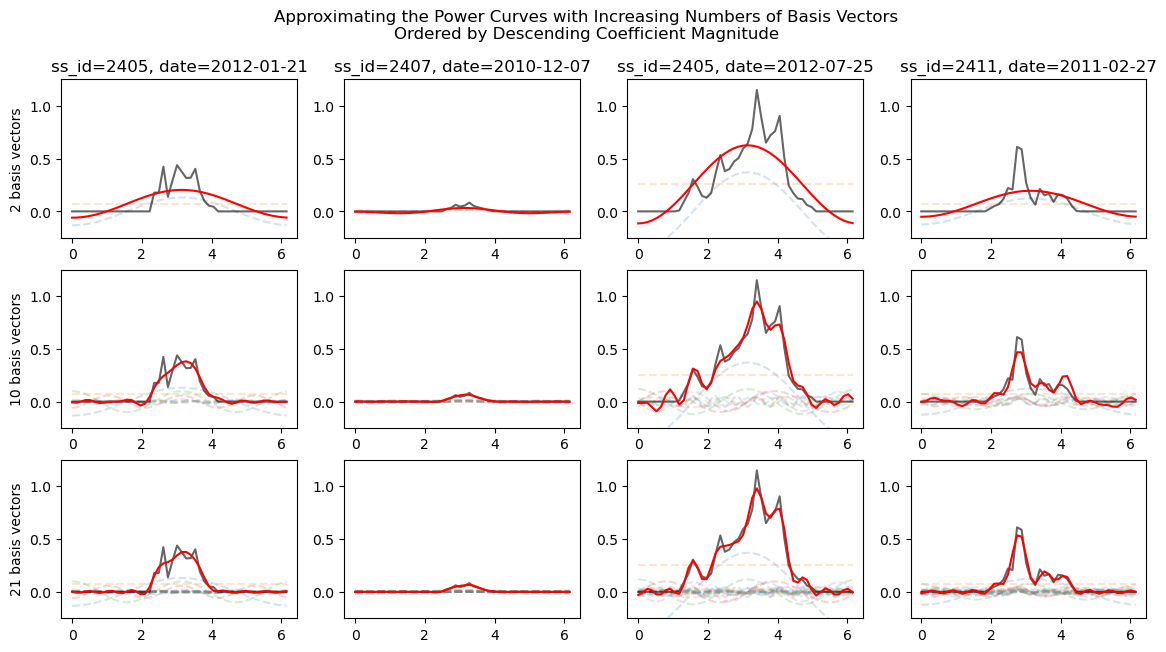

In [8]:
# %%time
### Compare the projections to the original
result = df.take(100)
result_ind = [0, 30, 2, 95]
n_vectors = [2, int(basis.shape[0]/2), basis.shape[0]]

fig, axes = plt.subplots(len(n_vectors), len(result_ind), figsize = (14,7))
plt.suptitle("Approximating the Power Curves with Increasing Numbers of Basis Vectors\nOrdered by Descending Coefficient Magnitude")
print("Coefficient indices for the ss_id/date pairings in descending order of coefficient magnitude")
for ax_i,n_vector in enumerate(n_vectors):
    for ax_j,n in enumerate(result_ind):
        id = result[n][0]
        ss_id = result[n][1]
        date = result[n][2]
        values = result[n][3]
        coeffs = np.array(result[n][4])
        
        # Sort basis vectors by coefficient to plot most important components
        coeffs_ind = np.argsort(np.absolute(coeffs))[::-1]
        coeffs = coeffs[coeffs_ind][:n_vector]
        basis_plot = basis[coeffs_ind, :]#[:n_vector,:]

        # Plot the projections
        projections = []
        for i,(coeff,vec) in enumerate(zip(coeffs, basis_plot)):
            projection = coeff * vec
            projections.append(projection)

            axes[ax_i, ax_j].plot(x, projection, linestyle="--", alpha=0.2)
            
        # Plot the mean vector and the sum of the projections
        projections = np.array(projections)
        mean_vec = np.sum(projections, axis=0)
        
        if ax_i==0:
            axes[ax_i, ax_j].set_title(f"ss_id={ss_id}, date={date}")
            print(f"{id}, {ss_id}, {date}: {coeffs_ind}")
        if ax_j==0:
            axes[ax_i, ax_j].set_ylabel(f"{n_vector} basis vectors")

        axes[ax_i, ax_j].plot(x, values, color="black", alpha=0.6)
        axes[ax_i, ax_j].plot(x, mean_vec, color="red")
        axes[ax_i, ax_j].set_ylim([-0.25, 1.25])

In [9]:
# Get reconstructions for all rows
df2 = df.rdd.map(lambda a: ((a[0], a[1], a[2], a[3], a[4]), 
                            np.dot(np.array(a[4]), basis))) \
            .map(lambda b: (b[0][0], b[0][1], b[0][2], b[0][3], b[0][4], b[1].tolist())) \
            .toDF(["id", "ss_id", "stamp_date", "power_kW_values", "coefficients", "reconstructions"])

test = df2.show(3)

+---+-----+----------+--------------------+--------------------+--------------------+
| id|ss_id|stamp_date|     power_kW_values|        coefficients|     reconstructions|
+---+-----+----------+--------------------+--------------------+--------------------+
|  0| 2405|2012-01-21|[0.0, 0.0, 0.0, 0...|[0.49785779737625...|[0.00410907621307...|
|  1| 2405|2012-02-15|[0.0, 0.0, 0.0, 0...|[1.27955253409150...|[-5.8784316146980...|
|  2| 2405|2012-07-25|[0.0, 0.0, 0.0, 0...|[1.77050233549690...|[-0.0294082997826...|
+---+-----+----------+--------------------+--------------------+--------------------+
only showing top 3 rows



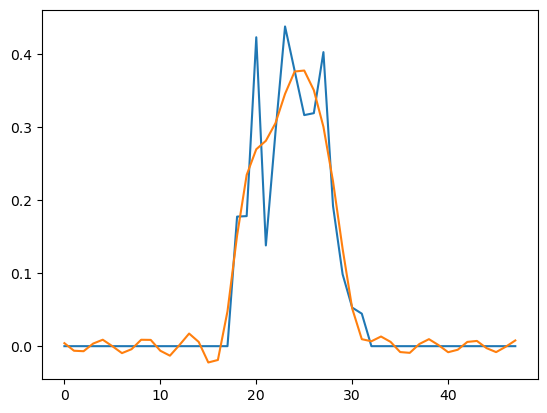

In [10]:
test_power = np.array(df2.select("power_kW_values").take(1)[0][0])
test_recon = np.array(df2.select("reconstructions").take(1)[0][0])

x = np.array([i for i in np.arange(0, 48)])
plt.plot(x, test_power)
plt.plot(x, test_recon)



In [19]:
%%time
### Comparing the mean generation curve with the mean reconstruction curve
df_power = df2.select("id", F.posexplode("power_kW_values")) \
              .groupBy("pos") \
              .agg(F.mean("col").alias("mean_power"),
                   F.std("col").alias("std_power")) \
              .toPandas()

df_recon = df2.select("id", F.posexplode("reconstructions")) \
              .groupBy("pos") \
              .agg(F.mean("col").alias("mean_recon"),
                   F.std("col").alias("std_recon")) \
              .toPandas()


CPU times: user 43.6 ms, sys: 28.8 ms, total: 72.4 ms
Wall time: 8min 52s


In [27]:
df_power[["mean_power", "std_power"]].describe()

,mean_power,std_power
count,48.000000,4.800000e+01
mean,28.434533,1.739405e+05
std,97.260472,5.694504e+05
min,0.000999,5.658613e-01
25%,0.143815,2.463271e+02
50%,1.049782,4.272789e+03
75%,2.700385,1.497389e+04
max,541.220781,2.830320e+06


In [30]:
df_recon[["mean_recon", "std_recon"]].describe()

,mean_recon,std_recon
count,48.000000,4.800000e+01
mean,28.434533,2.506729e+05
std,72.786902,3.041069e+05
min,-53.615790,5.199798e+04
25%,-13.405130,8.566137e+04
50%,11.564389,1.421449e+05
75%,25.825666,2.174146e+05
max,248.362589,1.248193e+06


----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 51758)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/socketserver.py", line 317, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/opt/conda/lib/python3.11/socketserver.py", line 348, in process_request
    self.finish_request(request, client_address)
  File "/opt/conda/lib/python3.11/socketserver.py", line 361, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/opt/conda/lib/python3.11/socketserver.py", line 755, in __init__
    self.handle()
  File "/usr/local/spark/python/pyspark/accumulators.py", line 295, in handle
    poll(accum_updates)
  File "/usr/local/spark/python/pyspark/accumulators.py", line 267, in poll
    if self.rfile in r and func():
                           ^^^^^^
  File "/usr/local/spark/python/pyspark/accumulators.py", line 271, in accum_updates
    num_updates =

CPU times: user 47.2 ms, sys: 2.12 ms, total: 49.4 ms
Wall time: 48.4 ms


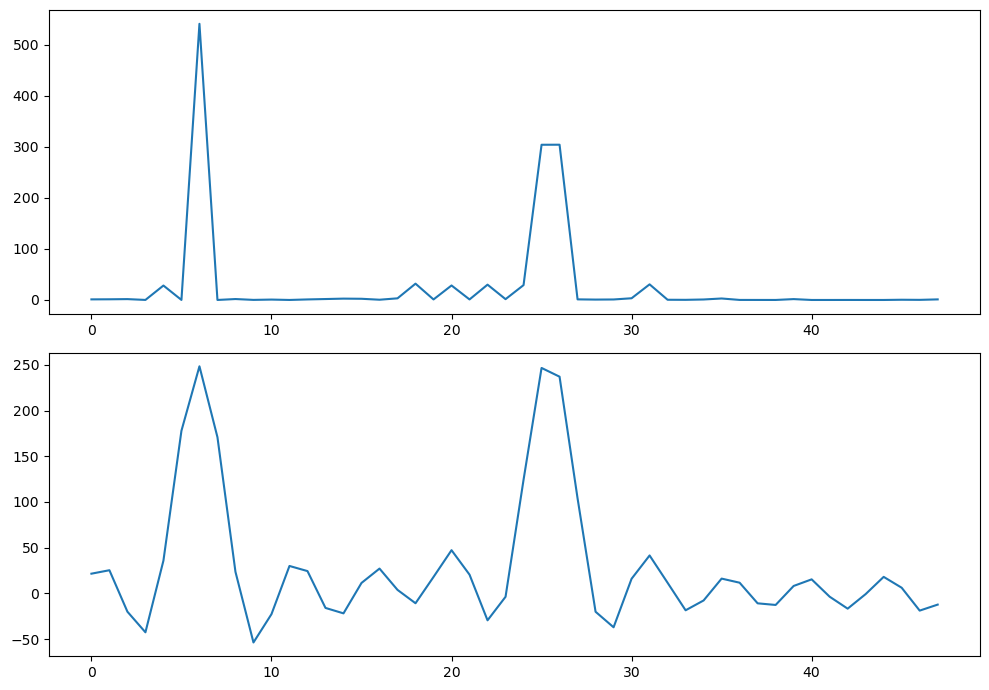

In [26]:
%%time
### Plotting
df_power = df_power.sort_values("pos")
df_recon = df_recon.sort_values("pos")

fig,ax = plt.subplots(2, 1, figsize=(10,7))
ax[0].plot(df_power["pos"], df_power["mean_power"])

ax[1].plot(df_recon["pos"], df_recon["mean_recon"])

plt.tight_layout()

# Getting Coefficient PCAs and Top 2 PCs

In [10]:
### Visualize the dataset by reducing power_kW_values to 2 Dimensions

### Define function to get covariance and other related stats
def compute_covariance_matrix(df, col):
    ### Map steps --> Incorporating NaN handling
    # 1: Create an array and insert 1 into element 0 (vec_length being max_timestamps + 1)
    # 2: Get the outer product of the array and indices of non-null values (as 1)
    # 3: Reduce to get two matrices: matrix sum and non-null indices
    sums_nonNullCounts =  df.select(col) \
                            .rdd.map(lambda a: (np.array([1] + a[0]))) \
                                .map(lambda b: (np.outer(b, b), 1-np.outer(b,b))) \
                                .reduce(lambda c1, c2: (np.nansum(np.dstack((c1[0], c2[0])), axis=2), c1[1] + c2[1])) \

    # S: Sum, NNC: Non-Null Count
    S, N = sums_nonNullCounts

    # Get E(x) --> Ex = Mean of df2_S[0, 1:]
    S_x = S[0, 1:]
    NNC_x = N[0, 1:]
    Ex = S_x/NNC_x

    # Get E(xxT) --> ExxT = Mean of df2_S[1:,1:]
    S_xxT = S[1:, 1:]
    NNC_xxT = N[1:, 1:]
    ExxT = S_xxT/NNC_xxT

    # Get covariance
    cov = ExxT - np.outer(Ex, Ex)

    output = [cov, Ex]

    return output

def get_ordered_eigval_eigvec(cov):
    ### Extract the eigenvalues and eigenvectors, then output them ordered by eigenvalue magnitude
    eigval, eigvec = np.linalg.eig(cov)
    eigval_ind = np.argsort(np.absolute(eigval))[::-1]
    output = [eigval[eigval_ind], eigvec[eigval_ind]]
    
    return output

def plot_explained_variance(eigval, max_num = None):
    ### View the amount of variance explained by each eigvenvector
    if max_num is None:
        max_num = len(eigval)
    total_var = np.sum(np.absolute(eigval))
    explained_var = []
    for i in range(0,max_num):
        explained_var.append((sum(np.absolute(eigval[:i])) / total_var) * 100)
        print(f"Up to vector {i}: {explained_var[i]}")
        
    plt.plot(range(0,max_num), explained_var)
    plt.title("Variance Explained by Eigenvectors")
    plt.xlabel("Number of Eigenvectors")
    plt.ylabel("% of Variance Explained")
    plt.show()




In [14]:
### PCA on coefficients to visualize them
col = "reconstructions"
### Calculate covariance matrix
cov, colMeans = compute_covariance_matrix(df2, col)
### Perform eigenvalue decomposition to get eigenvalues/eigenvectors of covariance matrix
eigval, eigvec = get_ordered_eigval_eigvec(cov)

Up to vector 0: 0.0
Up to vector 1: 99.61661653381259
Up to vector 2: 99.99999930588301
Up to vector 3: 99.99999938815367
Up to vector 4: 99.99999946874173


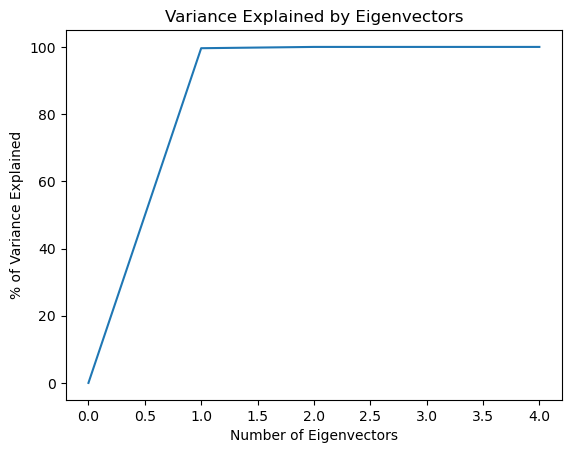

In [15]:
### Plot the amount of explained variance
plot_explained_variance(eigval, 5)

In [16]:
df2.show(1)

+---+-----+----------+--------------------+--------------------+--------------------+
| id|ss_id|stamp_date|     power_kW_values|        coefficients|     reconstructions|
+---+-----+----------+--------------------+--------------------+--------------------+
|  0| 2405|2012-01-21|[0.0, 0.0, 0.0, 0...|[0.49785779737625...|[0.00410907621307...|
+---+-----+----------+--------------------+--------------------+--------------------+
only showing top 1 row



In [20]:
### Get a representation for each data point along the 2 principal components
def get_top2_PC(df, eigvec):
    ### Convert dataframe coefficient to top 2 principal components
    # input: id, ss_id, stamp_date, power_kW_values, coefficients, reconstructions
    # output: id, ss_id, stamp_date, power_kW_values, coefficients, reconstructions, pc, pc1, pc2
    output = df.rdd.map(lambda a: ((a[0], a[1], a[2], a[3], a[4], a[5]), np.nan_to_num(np.array(a[5])).reshape(1, len(a[5])), 2)) \
               .map(lambda b: (b[0], np.dot(b[1], eigvec[0:2].T))) \
               .map(lambda b: (b[0][0], b[0][1], b[0][2], b[0][3], b[0][4], b[0][5], b[1][0].tolist(), float(b[1][0][0]), float(b[1][0][1]))) \
               .toDF(["id", "ss_id", "stamp_date", "power_kW_values", "coefficients", "reconstructions", "PC", "PC1", "PC2"])

    return output

df3 = get_top2_PC(df2, eigvec)

df3.show(1, vertical=True)

-RECORD 0-------------------------------
 id              | 0                    
 ss_id           | 2405                 
 stamp_date      | 2012-01-21           
 power_kW_values | [0.0, 0.0, 0.0, 0... 
 coefficients    | [0.49785779737625... 
 reconstructions | [0.00410907621307... 
 PC              | [-0.4178259582696... 
 PC1             | -0.41782595826965074 
 PC2             | -0.02458836598737569 
only showing top 1 row



In [21]:
### Saving the covariance matrix
pd.DataFrame(cov).to_csv("datasets/reconstruction_cov.csv", header=False, index=False)

In [22]:
### Saving the column means
pd.DataFrame(colMeans).to_csv("datasets/reconstruction_means.csv", header=False, index=False)

In [24]:
### Saving the new preprocessed df
df3.repartition(1).write.mode("overwrite").parquet("preprocessed_df_single_2")